In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image
np.random.seed(123)
from sklearn.preprocessing import label_binarize
from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils import to_categorical# used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
from keras import backend as K
import itertools
from tensorflow.keras.layers import BatchNormalization
from keras.utils import to_categorical # convert to one-hot-encoding
from sklearn.metrics import roc_curve, auc, roc_auc_score
from keras.optimizers import Adam
from tensorflow.keras.optimizers.legacy import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

print(os.listdir("E:/medical_plant"))

['jahe', 'kencur', 'lengkuas', 'medical_plant_metadata.csv', '~$medical_plant_metadata.xlsx']


In [9]:
def plot_model_history(model_history):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    # summarize history for accuracy
    axs[0].plot(range(1, len(model_history.history['accuracy']) + 1), model_history.history['accuracy'])
    axs[0].plot(range(1, len(model_history.history['val_accuracy']) + 1), model_history.history['val_accuracy'])
    axs[0].set_title('Model Accuracy')
    axs[0].set_ylabel('Accuracy')
    axs[0].set_xlabel('Epoch')
    axs[0].set_xticks(np.arange(1, len(model_history.history['accuracy']) + 1, len(model_history.history['accuracy']) // 10))
    axs[0].legend(['train', 'val'], loc='best')
    # summarize history for loss
    axs[1].plot(range(1, len(model_history.history['loss']) + 1), model_history.history['loss'])
    axs[1].plot(range(1, len(model_history.history['val_loss']) + 1), model_history.history['val_loss'])
    axs[1].set_title('Model Loss')
    axs[1].set_ylabel('Loss')
    axs[1].set_xlabel('Epoch')
    axs[1].set_xticks(np.arange(1, len(model_history.history['loss']) + 1, len(model_history.history['loss']) // 10))
    axs[1].legend(['train', 'val'], loc='best')
    plt.show()


In [10]:
base_skin_dir = 'E:/medical_plant'

imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

plant_type_dict = {
    'lk': 'Lengkuas',
    'jh': 'Jahe',
    'kc': 'Kencur'
}

In [11]:
plant_df = pd.read_csv(os.path.join(base_skin_dir, 'E:/medical_plant/medical_plant_metadata.csv'))

In [12]:
plant_df['path'] = plant_df['image_id'].map(imageid_path_dict.get)
plant_df['cell_type'] = plant_df['dx'].map(plant_type_dict.get) 
plant_df['cell_type_idx'] = pd.Categorical(plant_df['cell_type']).codes

In [13]:
plant_df.head()

,plant_id,image_id,dx,path,cell_type,cell_type_idx
0,plant_01,lk_1,lk,E:/medical_plant\lengkuas\lk_1.jpg,Lengkuas,2
1,plant_02,lk_2,lk,E:/medical_plant\lengkuas\lk_2.jpg,Lengkuas,2
2,plant_03,lk_3,lk,E:/medical_plant\lengkuas\lk_3.jpg,Lengkuas,2
3,plant_04,lk_4,lk,E:/medical_plant\lengkuas\lk_4.jpg,Lengkuas,2
4,plant_05,lk_5,lk,E:/medical_plant\lengkuas\lk_5.jpg,Lengkuas,2


In [14]:
plant_df.isnull().sum()

plant_id         0
image_id         0
dx               0
path             0
cell_type        0
cell_type_idx    0
dtype: int64

In [15]:
print(plant_df.dtypes)

plant_id         object
image_id         object
dx               object
path             object
cell_type        object
cell_type_idx      int8
dtype: object


<Axes: xlabel='cell_type'>

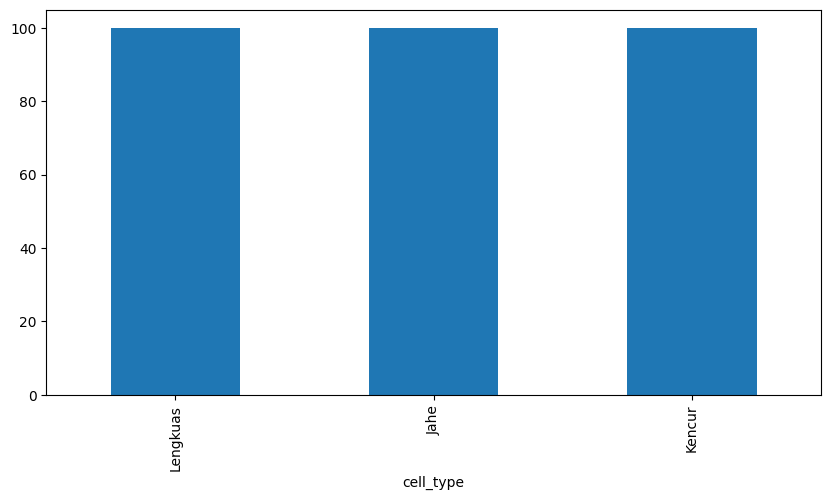

In [16]:
fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
plant_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [17]:
plant_df['image'] = plant_df['path'].map(lambda x: np.asarray(Image.open(x).resize((100,75))))

In [18]:
plant_df.head()

,plant_id,image_id,dx,path,cell_type,cell_type_idx,image
0,plant_01,lk_1,lk,E:/medical_plant\lengkuas\lk_1.jpg,Lengkuas,2,"[[[97, 92, 102], [97, 93, 103], [98, 95, 102],..."
1,plant_02,lk_2,lk,E:/medical_plant\lengkuas\lk_2.jpg,Lengkuas,2,"[[[101, 100, 112], [101, 101, 113], [104, 102,..."
2,plant_03,lk_3,lk,E:/medical_plant\lengkuas\lk_3.jpg,Lengkuas,2,"[[[118, 120, 132], [119, 121, 134], [120, 123,..."
3,plant_04,lk_4,lk,E:/medical_plant\lengkuas\lk_4.jpg,Lengkuas,2,"[[[116, 115, 123], [116, 115, 125], [118, 116,..."
4,plant_05,lk_5,lk,E:/medical_plant\lengkuas\lk_5.jpg,Lengkuas,2,"[[[104, 103, 117], [105, 104, 117], [106, 105,..."


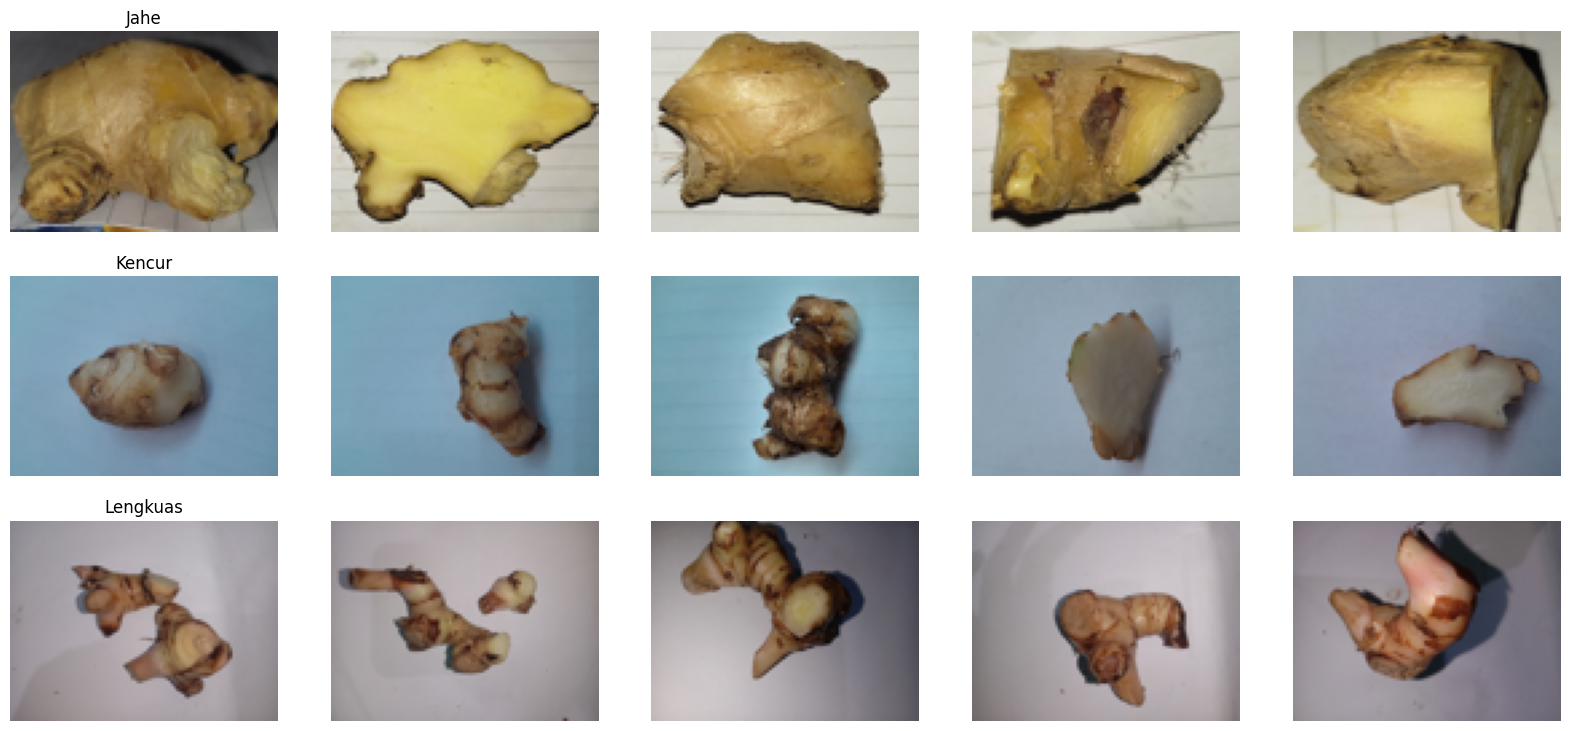

In [19]:
n_samples = 5
fig, m_axs = plt.subplots(3, n_samples, figsize=(4 * n_samples, 3 * 3))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         plant_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
fig.savefig('category_samples.png', dpi=300)


In [20]:
plant_df['image'].map(lambda x: x.shape).value_counts()

image
(75, 100, 3)    300
Name: count, dtype: int64

In [21]:
features=plant_df.drop(columns=['cell_type_idx'],axis=1)
target=plant_df['cell_type_idx']

In [22]:
x_train_o, x_test_o, y_train_o, y_test_o = train_test_split(features, target, test_size=0.20,random_state=1234)

In [23]:
x_train = np.asarray(x_train_o['image'].tolist())
x_test = np.asarray(x_test_o['image'].tolist())

x_train_mean = np.mean(x_train)
x_train_std = np.std(x_train)

x_test_mean = np.mean(x_test)
x_test_std = np.std(x_test)

x_train = (x_train - x_train_mean)/x_train_std
x_test = (x_test - x_test_mean)/x_test_std

In [24]:
y_train = to_categorical(y_train_o, num_classes = 3)
y_test = to_categorical(y_test_o, num_classes = 3)

In [25]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [26]:
x_train = x_train.reshape(x_train.shape[0], *(75, 100, 3))
x_test = x_test.reshape(x_test.shape[0], *(75, 100, 3))
x_validate = x_validate.reshape(x_validate.shape[0], *(75, 100, 3))

In [27]:
input_shape = (75, 100, 3)
num_classes = 3

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding = 'Same',input_shape=input_shape))
model.add(Conv2D(32,kernel_size=(3, 3), activation='relu',padding = 'Same',))
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(Conv2D(64, (3, 3), activation='relu',padding = 'Same'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 100, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2  (None, 37, 50, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 37, 50, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 50, 64)        36928     
                                                        

In [28]:
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7, decay=0.0, amsgrad=False)

In [29]:
model.compile(optimizer = optimizer , loss = "categorical_crossentropy", metrics=["accuracy"])

In [30]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=3, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [31]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

datagen.fit(x_train)

In [32]:
epochs = 50 
batch_size = 10
history = model.fit(datagen.flow(x_train,y_train, batch_size=batch_size),
                              epochs = epochs, validation_data = (x_validate,y_validate),
                              verbose = 1, steps_per_epoch=x_train.shape[0] // batch_size
                              , callbacks=[learning_rate_reduction])

Epoch 1/50
21/21 [==============================] - 3s 125ms/step - loss: 0.6760 - accuracy: 0.7718 - val_loss: 0.1163 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 2/50
21/21 [==============================] - 2s 117ms/step - loss: 0.1143 - accuracy: 0.9757 - val_loss: 0.6668 - val_accuracy: 0.7500 - lr: 0.0010
Epoch 3/50
21/21 [==============================] - 2s 117ms/step - loss: 0.1413 - accuracy: 0.9806 - val_loss: 0.0661 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 4/50
21/21 [==============================] - ETA: 0s - loss: 0.0455 - accuracy: 0.9951
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
21/21 [==============================] - 3s 119ms/step - loss: 0.0455 - accuracy: 0.9951 - val_loss: 0.1535 - val_accuracy: 0.9583 - lr: 0.0010
Epoch 5/50
21/21 [==============================] - 2s 118ms/step - loss: 0.0522 - accuracy: 0.9903 - val_loss: 0.0765 - val_accuracy: 0.9583 - lr: 5.0000e-04
Epoch 6/50
21/21 [==============================] - 2s 118ms/s

In [33]:
loss, accuracy = model.evaluate(x_test, y_test, verbose=1)
loss_v, accuracy_v = model.evaluate(x_validate, y_validate, verbose=1)
print("Validation: accuracy = %f  ;  loss_v = %f" % (accuracy_v, loss_v))
print("Test: accuracy = %f  ;  loss = %f" % (accuracy, loss))
model.save("model.h5")

1/1 [==============================] - 0s 66ms/step - loss: 0.0089 - accuracy: 1.0000
Validation: accuracy = 1.000000  ;  loss_v = 0.008862
Test: accuracy = 0.983333  ;  loss = 0.018063


C:\Users\ASUS\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


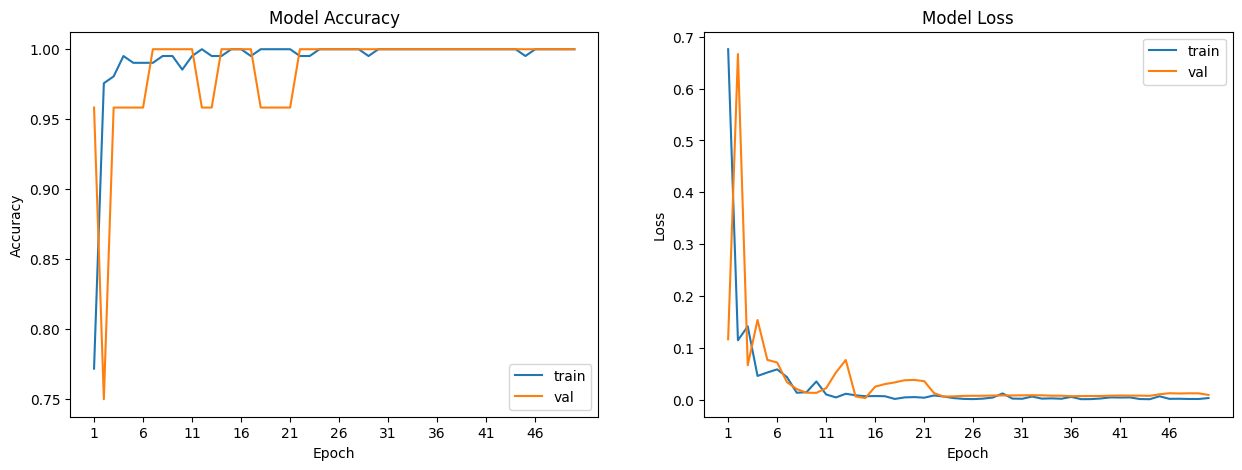

In [34]:
plot_model_history(history)

1/1 [==============================] - 0s 69ms/step


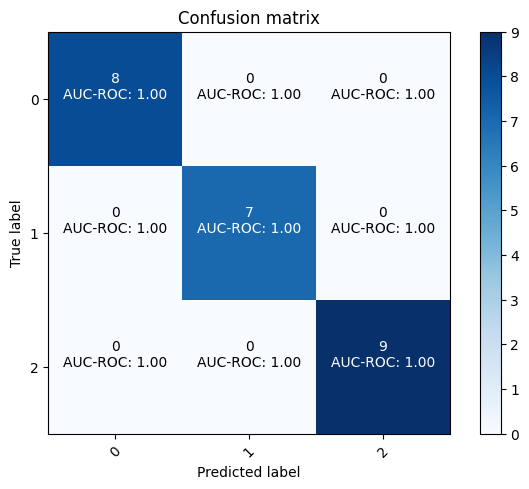

In [40]:
def plot_confusion_matrix_with_auc(cm, classes, auc_roc, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix with AUC-ROC information.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]}\nAUC-ROC: {auc_roc[i]:.2f}",
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(x_validate)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred, axis=1) 
# Convert validation observations to one hot vectors
Y_true = np.argmax(y_validate, axis=1) 
# Compute the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Compute AUC-ROC for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = y_validate.shape[1]

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_validate[:, i], Y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot the confusion matrix with AUC-ROC information
plot_confusion_matrix_with_auc(confusion_mtx, classes=range(3), auc_roc=roc_auc)


Text(0, 0.5, 'Fraction classified incorrectly')

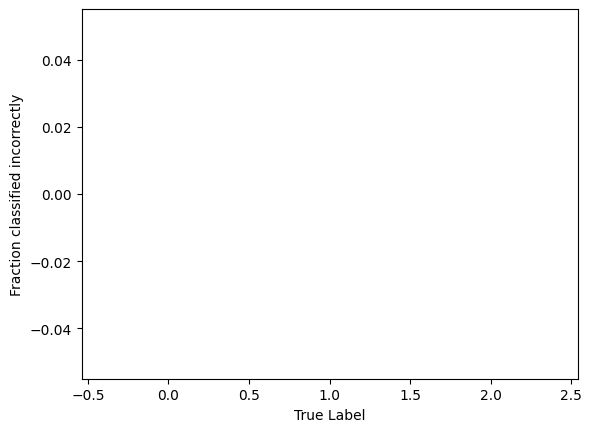

In [41]:
label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)
plt.bar(np.arange(3),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [42]:
report = classification_report(Y_true, Y_pred_classes)
print(report)

              precision    recall  f1-score   support

           0       1.00      1.00      1.00         8
           1       1.00      1.00      1.00         7
           2       1.00      1.00      1.00         9

    accuracy                           1.00        24
   macro avg       1.00      1.00      1.00        24
weighted avg       1.00      1.00      1.00        24

